In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.modules
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

print("Pytorch version:",torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Pytorch version: 0.4.0


# Data

The MNIST data is PIL image range from 0 to 1. We'll transform them to range [-1, 1]. The image size is 28x28 grayscale, therefore each minibatch will have shape (128, 1, 28, 28)

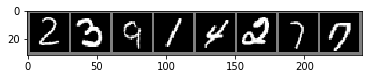

    2     3     9     1     4     2     7     7


In [2]:
batch_size = 100
labels_dim = 10

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show some images
imshow(torchvision.utils.make_grid(images[0:8]))
# print labels
print(' '.join('%5s' % labels[j].numpy() for j in range(8)))

# Generator Network

For each minibatch, the purpose of G (short of generator) is to take random noise as input and generate image with shape (1,28,28). In here, we're going to use transpose convolutional layer as proposed in DCGAN to upscale the tensors to finally match the intended image dimension. You can read more on transpose conv in https://arxiv.org/pdf/1603.07285.pdf and see visualization here https://github.com/vdumoulin/conv_arithmetic. When performing normal convolutional, the output size will be smaller than the input size. Transpose convolutional basically generate output with size larger than input.

We want the tensors from layer output to have following shapes:
- input: (batch_size, 100, 1, 1)
- deconv1: (batch_size, 512, 7, 7). 
- deconv2: (batch_size, 256, 14, 14)
- deconv3: (batch_size, 1, 28, 28). This is the image dimension - 1 colour channel and 28x28 resolution.

The 2nd dimension is equal to the number of filter. The easiest way to determine the kernel size and padding would be to assume we're doing convolutional backward from higher layer to lower layer. We can use the formula from http://cs231n.github.io/convolutional-networks/

O=(W−F+2P)/S+1 

where O=output, W=input dim, F=kernel dim, P=padding, S=stride

We can reognize the equation to be:

F = W-(O-1)S+2P

To work out the the number of padding for the top (last) tranpose layer, we substitute O = 14, W=28, S=2, and try different values of P e.g. 0, 1, 2.. to get corresponding F.

In [3]:
nz = 100

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

        
class Generator(nn.Module):
    def __init__(self, nc=1, ngf=64):
        super(Generator, self).__init__()
        self.
        self.model = nn.Sequential(
            # input shape : (n, nz, 1, 1)
            nn.ConvTranspose2d(nz, ngf*8, 7, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            
            # input shape : (n, ngf*8, 7, 7)
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),            
            
            # input shape : (n, ngf*4, 14, 14)
            nn.ConvTranspose2d(ngf*4, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            
            # output shape : (n, 1, 28, 28)            
        
        )
    def forward(self, input):
        output = self.model(input)
        return output
    
netG = Generator().to(device)
netG.apply(weights_init)


Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input shape : (n, nc, 28, 28)
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # input shape : (n, ndf, 14, 14)
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),            
            
            # input shape : (n, ndf*2, 7, 7)
            nn.Conv2d(ndf*2, 1, 7, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.model(input)
        return output.view(-1,1).squeeze(1)
    
netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 1, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (6): Sigmoid()
  )
)

In [5]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

[0] Loss_D: 1.3606  Loss_G: 1.2673


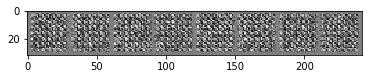

[1] Loss_D: 0.8899  Loss_G: 1.1230


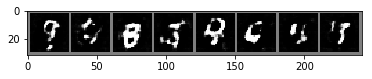

[2] Loss_D: 0.8540  Loss_G: 1.4626


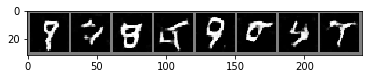

[3] Loss_D: 0.8549  Loss_G: 1.9666


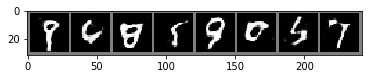

[4] Loss_D: 0.9054  Loss_G: 1.0716


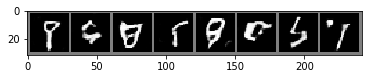

[5] Loss_D: 0.7805  Loss_G: 1.3309


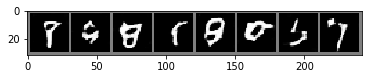

[6] Loss_D: 0.7939  Loss_G: 1.8171


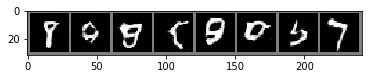

[7] Loss_D: 0.9039  Loss_G: 1.3173


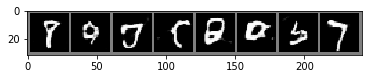

[8] Loss_D: 1.0898  Loss_G: 1.3988


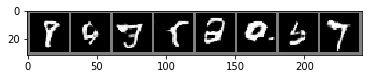

[9] Loss_D: 0.7508  Loss_G: 1.7862


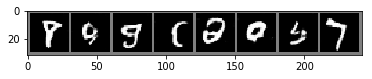

[10] Loss_D: 0.9217  Loss_G: 1.0262


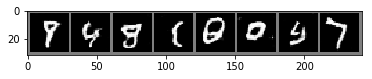

[11] Loss_D: 0.9782  Loss_G: 1.2622


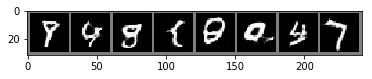

[12] Loss_D: 0.9237  Loss_G: 1.4175


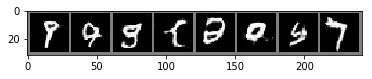

[13] Loss_D: 0.8587  Loss_G: 1.8238


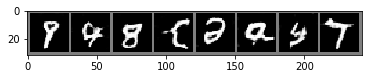

[14] Loss_D: 0.8368  Loss_G: 1.6499


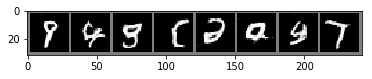

[15] Loss_D: 1.8881  Loss_G: 0.7290


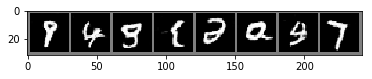

[16] Loss_D: 0.9594  Loss_G: 1.0515


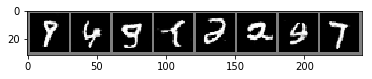

[17] Loss_D: 0.8483  Loss_G: 1.6472


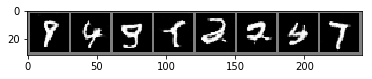

[18] Loss_D: 1.1253  Loss_G: 0.7896


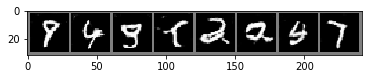

[19] Loss_D: 0.8802  Loss_G: 1.4595


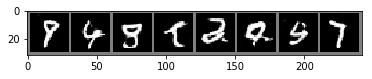

[20] Loss_D: 0.9310  Loss_G: 1.0737


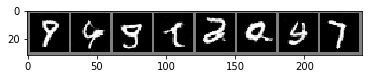

[21] Loss_D: 0.8241  Loss_G: 1.8874


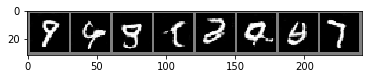

[22] Loss_D: 0.8397  Loss_G: 1.2557


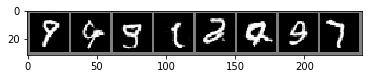

[23] Loss_D: 0.9140  Loss_G: 0.8777


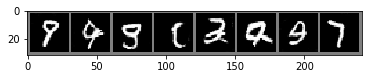

[24] Loss_D: 1.0727  Loss_G: 1.1536


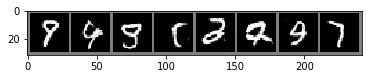

[25] Loss_D: 0.8468  Loss_G: 1.4837


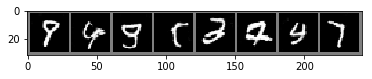

[26] Loss_D: 0.8643  Loss_G: 2.1474


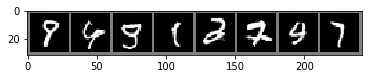

[27] Loss_D: 0.9460  Loss_G: 1.9486


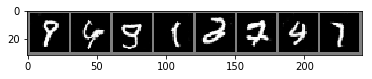

[28] Loss_D: 0.9038  Loss_G: 1.6325


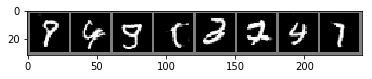

[29] Loss_D: 0.9335  Loss_G: 2.1537


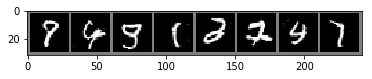

[30] Loss_D: 0.9968  Loss_G: 1.1774


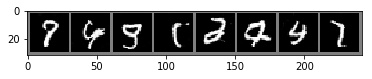

[31] Loss_D: 0.9283  Loss_G: 1.2712


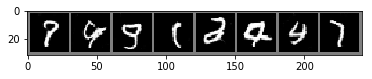

[32] Loss_D: 0.8642  Loss_G: 1.2383


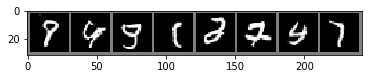

[33] Loss_D: 1.0299  Loss_G: 1.3257


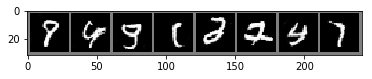

[34] Loss_D: 0.8550  Loss_G: 1.6561


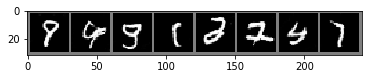

[35] Loss_D: 0.8588  Loss_G: 1.2953


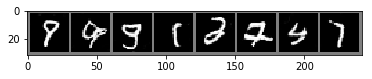

[36] Loss_D: 0.9418  Loss_G: 1.5794


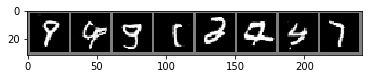

[37] Loss_D: 0.9428  Loss_G: 1.6108


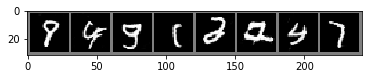

[38] Loss_D: 0.9168  Loss_G: 1.6938


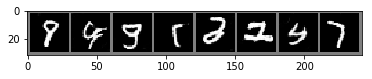

[39] Loss_D: 0.8838  Loss_G: 1.5094


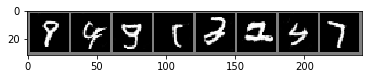

[40] Loss_D: 0.9566  Loss_G: 1.5399


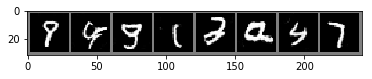

[41] Loss_D: 0.9254  Loss_G: 1.2815


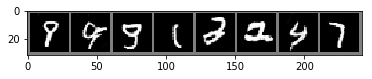

[42] Loss_D: 0.9508  Loss_G: 0.9609


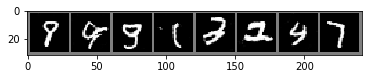

[43] Loss_D: 0.8163  Loss_G: 1.6417


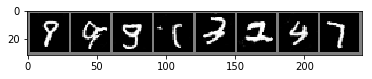

[44] Loss_D: 0.9396  Loss_G: 1.9857


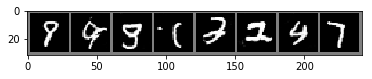

[45] Loss_D: 1.0109  Loss_G: 2.0167


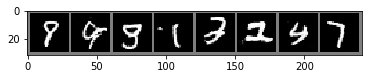

[46] Loss_D: 0.9053  Loss_G: 1.8004


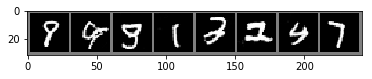

[47] Loss_D: 0.9997  Loss_G: 2.2368


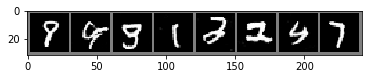

[48] Loss_D: 0.9169  Loss_G: 1.3549


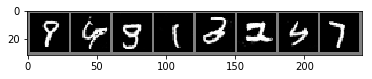

[49] Loss_D: 0.9836  Loss_G: 1.5963


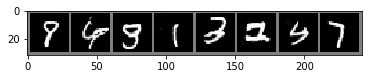

[50] Loss_D: 0.9328  Loss_G: 1.4931


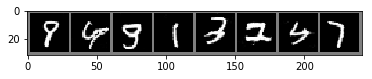

[51] Loss_D: 0.8909  Loss_G: 1.4047


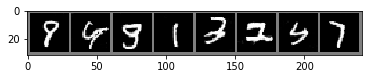

[52] Loss_D: 1.1117  Loss_G: 1.8872


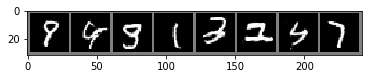

[53] Loss_D: 1.0745  Loss_G: 2.2425


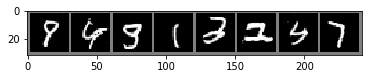

[54] Loss_D: 0.9417  Loss_G: 1.7730


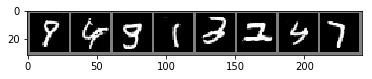

[55] Loss_D: 1.0114  Loss_G: 1.7940


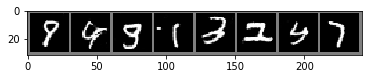

[56] Loss_D: 0.9968  Loss_G: 1.3696


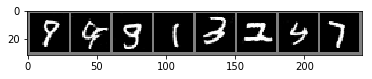

[57] Loss_D: 1.0230  Loss_G: 1.6817


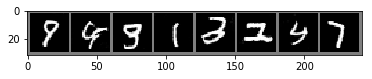

[58] Loss_D: 0.9692  Loss_G: 1.2490


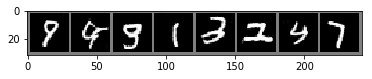

[59] Loss_D: 1.1401  Loss_G: 1.0520


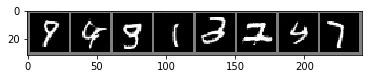

[60] Loss_D: 0.9808  Loss_G: 1.3816


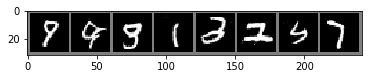

[61] Loss_D: 0.9058  Loss_G: 1.8336


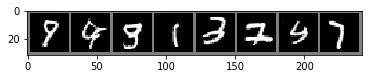

[62] Loss_D: 1.0264  Loss_G: 1.6554


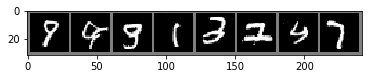

[63] Loss_D: 1.2168  Loss_G: 0.6771


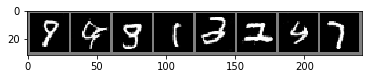

[64] Loss_D: 0.8972  Loss_G: 1.5056


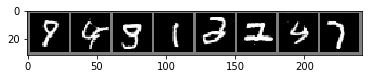

[65] Loss_D: 1.3084  Loss_G: 2.7419


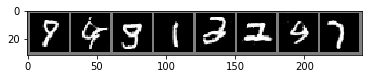

[66] Loss_D: 0.8748  Loss_G: 1.7369


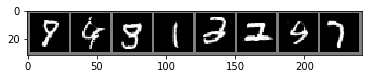

[67] Loss_D: 0.8900  Loss_G: 1.5299


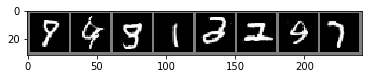

[68] Loss_D: 1.2935  Loss_G: 0.9728


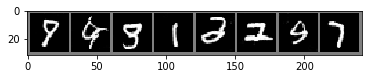

[69] Loss_D: 0.9868  Loss_G: 1.9307


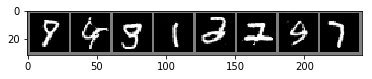

[70] Loss_D: 1.2489  Loss_G: 0.8818


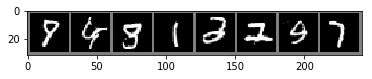

[71] Loss_D: 1.2202  Loss_G: 0.6886


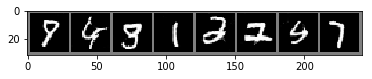

[72] Loss_D: 1.1143  Loss_G: 1.0720


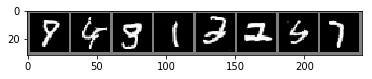

[73] Loss_D: 1.6588  Loss_G: 0.4476


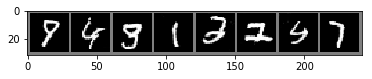

[74] Loss_D: 0.9421  Loss_G: 1.3173


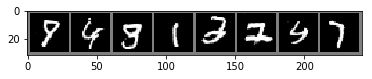

[75] Loss_D: 0.9580  Loss_G: 1.0926


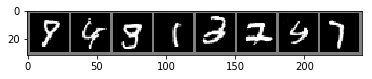

[76] Loss_D: 0.9700  Loss_G: 1.2992


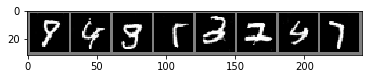

[77] Loss_D: 0.7865  Loss_G: 1.8166


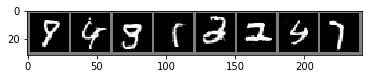

[78] Loss_D: 0.9299  Loss_G: 2.1355


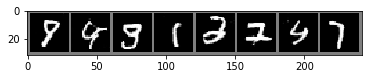

[79] Loss_D: 1.0117  Loss_G: 1.2412


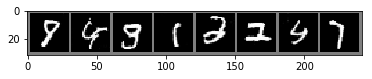

[80] Loss_D: 1.0722  Loss_G: 0.8715


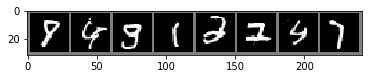

[81] Loss_D: 1.0096  Loss_G: 1.1842


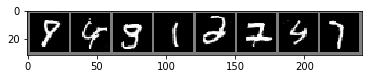

[82] Loss_D: 0.9768  Loss_G: 1.5760


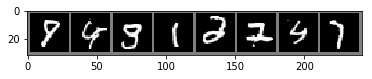

[83] Loss_D: 0.9339  Loss_G: 1.6651


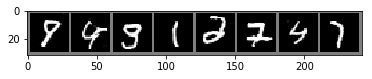

[84] Loss_D: 1.5070  Loss_G: 2.5789


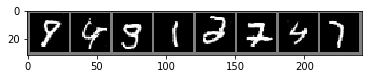

[85] Loss_D: 0.9987  Loss_G: 2.0521


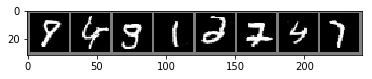

[86] Loss_D: 0.7808  Loss_G: 2.0924


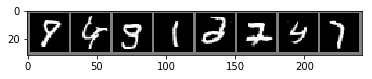

[87] Loss_D: 0.8477  Loss_G: 1.7145


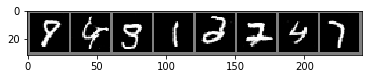

[88] Loss_D: 0.9231  Loss_G: 1.5245


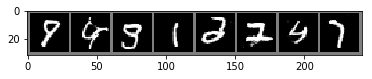

[89] Loss_D: 0.8888  Loss_G: 1.4570


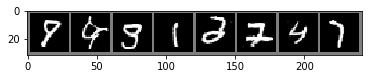

[90] Loss_D: 0.9169  Loss_G: 1.5437


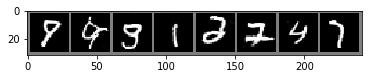

[91] Loss_D: 1.0113  Loss_G: 1.4887


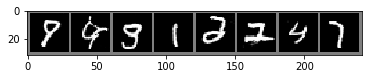

[92] Loss_D: 0.8649  Loss_G: 1.5960


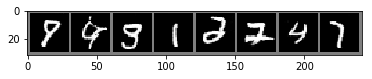

[93] Loss_D: 1.0924  Loss_G: 1.7038


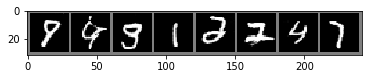

[94] Loss_D: 0.9276  Loss_G: 1.7061


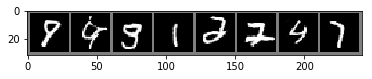

[95] Loss_D: 1.6769  Loss_G: 1.1999


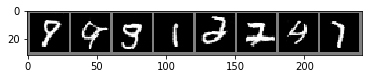

[96] Loss_D: 1.0727  Loss_G: 1.0922


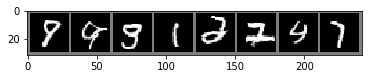

[97] Loss_D: 0.8613  Loss_G: 1.3909


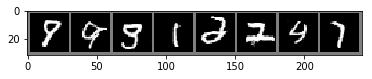

[98] Loss_D: 0.7894  Loss_G: 2.0169


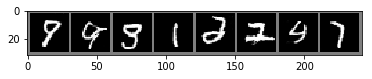

[99] Loss_D: 0.9574  Loss_G: 1.1842


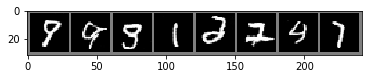

In [6]:
n_epoch = 100
n_show = 10000
n_save = 50

for epoch in range(n_epoch):
    for i, data in enumerate(trainloader, 0):
        # data[0] is images, data[1] is labels
        # Discriminator - real
        netD.zero_grad()
        
        real_data = data[0].to(device)
        batch_size = real_data.size(0)
        
        real_labels = torch.full((batch_size,), 0.9, device=device)
        g_real_labels = torch.full((batch_size,), 0.9, device=device)
        fake_labels = torch.full((batch_size,), 0, device=device)                
        
        
        output = netD(real_data)
        loss_d_real = criterion(output, real_labels)
        loss_d_real.backward()
        
        # Discriminator - fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_data = netG(noise)
        
        # detach G's output i.e. fake_data from D so G does not get backprop
        output = netD(fake_data.detach())
        loss_d_fake = criterion(output, fake_labels)
        loss_d_fake.backward()        
        
        # Discriminator - update 2 backprop
        optimizerD.step()
        
        loss_d_total = loss_d_real + loss_d_fake
        
        # Generator
        netG.zero_grad()
        output = netD(fake_data)
        loss_g = criterion(output, g_real_labels)
        loss_g.backward()
        
        optimizerG.step()
        
        
        # show image
        if i%n_show == 0:
            print('[%d] Loss_D: %.4f  Loss_G: %.4f'%(epoch, loss_d_total.item(), loss_g.item()))
            test_imgs = netG(fixed_noise)
            imshow(torchvision.utils.make_grid(test_imgs[0:8].detach().cpu()))
            
        if i%n_save == 0:
            torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % ('./models', epoch))
            torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % ('./models', epoch))